In [1]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd

In [5]:
num_classes = 1
input_shape = (1, 1,3)

In [6]:
path_to_images = '/content/image/Landsat8_136044_2013-12-17--2014-01-02.jpg'

# Create an empty list to store the image data
image_data_list = []

images = Image.open(path_to_images)

# Convert each image to a numpy array and append to the list
image_data_list.append(np.array(images))

# Convert the list of image data to a numpy array
image_data = np.array(image_data_list)
print(image_data.shape)
image_data = image_data.reshape(124416,1,1,3)

# Print the shape of the numpy array
print("Shape of image_data:", image_data.shape)


(1, 288, 432, 3)
Shape of image_data: (124416, 1, 1, 3)


In [7]:

thresh = 200

path_to_labels = '/content/label/Landsat8_136044_2013-12-17--2014-01-02_mask.jpg'

# Create an empty list to store the label data
label_data_list = []


labels = Image.open(path_to_labels)
fn = lambda x : 255 if x > thresh else 0
labels = labels.convert('L').point(fn, mode='1')


# Convert each label to a numpy array and append to the list
label_data_list.append(np.array(labels))

# Convert the list of label data to a numpy array
label_data = np.array(label_data_list)
print(label_data.shape)
label_data = label_data.reshape(124416,1)
# Print the shape of the numpy array
print("Shape of Label_data:", label_data.shape)

(1, 288, 432)
Shape of Label_data: (124416, 1)


In [8]:
label_data=label_data.astype(int)
print(len(label_data))

124416


In [9]:
print(label_data)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [10]:
np.unique(label_data)

array([0, 1])

In [11]:
#@title Default title text
# Split the data into training and testing sets
# Assuming that you have loaded your image and label data into x and y variables respectively
x_train, x_test, y_train, y_test = train_test_split(image_data,label_data, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (99532, 1, 1, 3) - y_train shape: (99532, 1)
x_test shape: (24884, 1, 1, 3) - y_test shape: (24884, 1)
x_train shape: (99532, 1, 1, 3) - y_train shape: (99532, 1)
x_test shape: (24884, 1, 1, 3) - y_test shape: (24884, 1)


In [12]:
learning_rate = 0.0001
weight_decay = 0.001
batch_size = 256
num_epochs = 5
image_size = 72 # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
            
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


256
(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


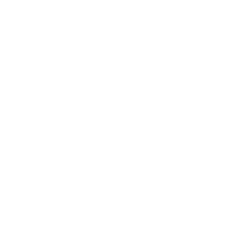

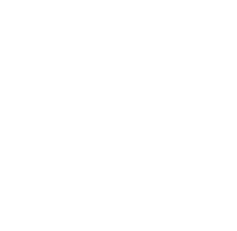

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

#print(image)

patches = Patches(patch_size)(resized_image)
print(batch_size)
print(resized_image.shape)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [18]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    print(logits)
    # Create the Keras model.
    print(inputs.shape)
    print(logits.shape)
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [19]:
print(x_train.shape)
print(y_train.shape)

(99532, 1, 1, 3)
(99532, 1)


In [20]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # model.compile(
    #     optimizer = optimizer,
    #     loss = 'categorical_crossentropy',
    #     metrics=['accuracy']

    # )

    model.compile(
        optimizer=optimizer,
        # loss=keras.losses.SparseCategoricalCrossentropy(),
        # metrics=[
        #     keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        #     keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        # ],
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()

    #callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

   
    return history


In [21]:
vit_classifier = create_vit_classifier()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_19/BiasAdd:0', description="created by layer 'dense_19'")
(None, 1, 1, 3)
(None, 1)


In [22]:
history = run_experiment(vit_classifier)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 1, 3)]    0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

389/389 [==============================] - 1965s 5s/step - loss: 0.2250 - accuracy: 0.9849 - val_loss: 0.2288 - val_accuracy: 0.9849
Epoch 2/5
389/389 [==============================] - 1936s 5s/step - loss: 0.2283 - accuracy: 0.9847 - val_loss: 0.1900 - val_accuracy: 0.9874
Epoch 3/5
389/389 [==============================] - 1950s 5s/step - loss: 0.2018 - accuracy: 0.9859 - val_loss: 0.1768 - val_accuracy: 0.9882
Epoch 4/5
389/389 [==============================] - 1936s 5s/step - loss: 0.0957 - accuracy: 0.9899 - val_loss: 0.0487 - val_accuracy: 0.9867
Epoch 5/5
389/389 [==============================] - 1941s 5s/step - loss: 0.0332 - accuracy: 0.9908 - val_loss: 0.0212 - val_accuracy: 0.9912


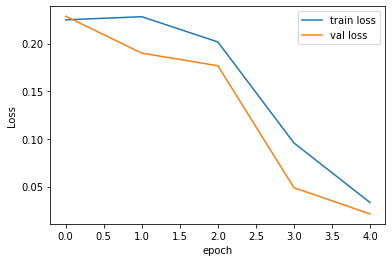

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

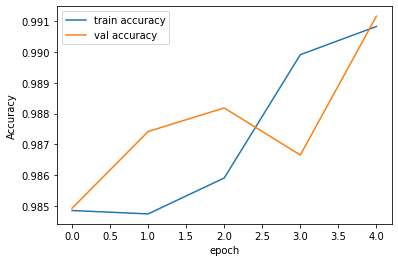

In [24]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

In [25]:
pred_train = vit_classifier.predict(x_train, batch_size=1)


print(len(pred_train))

99532/99532 [==============================] - 581s 6ms/step
99532


In [26]:
print(pred_train)

[[ 1.3442825 ]
 [ 1.3442825 ]
 [ 1.3442825 ]
 ...
 [ 1.3442825 ]
 [-0.17535107]
 [ 1.3442825 ]]


In [27]:
pred_train=pred_train.round()

In [28]:
np.unique(pred_train)

array([-0.,  1.], dtype=float32)

In [30]:
train_pred=[]
for i in range(len(pred_train)):
  
  if pred_train[i] > 0:
    train_pred.append(1)
  else:
    train_pred.append(0)

print(train_pred)

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report

In [32]:
accuracy = accuracy_score(y_train, train_pred)
print(accuracy)

0.9911586223526102


In [33]:
pred_test = vit_classifier.predict(x_test, batch_size=1)

24884/24884 [==============================] - 157s 6ms/step


In [34]:
print(pred_test)

[[-0.22796103]
 [ 1.3442825 ]
 [ 1.3442825 ]
 ...
 [ 1.3442825 ]
 [-0.21476676]
 [-0.22940825]]


In [35]:
np.unique(pred_test)

array([-0.28733355, -0.28699362, -0.28689104, ...,  1.4447454 ,
        1.4497446 ,  1.453435  ], dtype=float32)

In [36]:
test_pred=[]
for i in range(len(pred_test)):
  
  if pred_test[i] > 0:
    test_pred.append(1)
  else:
    test_pred.append(0)

print(test_pred)

[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 

In [37]:
accuracy = accuracy_score(y_test, test_pred)
print(accuracy)

0.9822375823822537


In [38]:
report = classification_report(y_test, test_pred)

In [39]:
accuracy = accuracy_score(y_test, test_pred)

precision = precision_score(y_test, test_pred, average='weighted')
f1 = f1_score(y_test, test_pred, average='weighted')
recall = recall_score(y_test, test_pred, average='weighted')
#Loss = history.history['loss'][4]
#print(history.history['loss'])
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("F1 Score", f1)
print("Recall:", recall)
report = classification_report(y_test, test_pred)
print(report)

Accuracy:  0.9822375823822537
Precision:  0.9827212518347367
F1 Score 0.9821507678793499
Recall: 0.9822375823822537
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      9438
           1       0.97      1.00      0.99     15446

    accuracy                           0.98     24884
   macro avg       0.99      0.98      0.98     24884
weighted avg       0.98      0.98      0.98     24884



In [40]:
import seaborn as sns

[[ 8998   440]
 [    2 15444]]


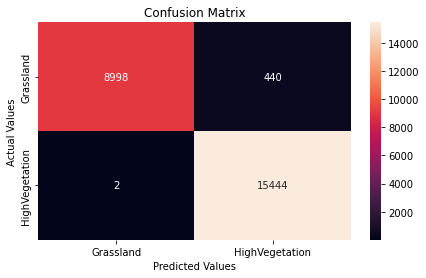

In [41]:
cm = confusion_matrix(y_test, test_pred)
print(cm)
    
    
cm_df = pd.DataFrame(cm,
                     index = ['Grassland','HighVegetation'], 
                     columns = ['Grassland','HighVegetation'])
    #Plotting the confusion matrix
plt.figure(figsize=(7,4))
sns.heatmap(cm_df, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()